<a href="https://colab.research.google.com/github/Maahira0810/Archaelogical_Project/blob/main/SOil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="MMFZWHhSvylkZHBxlS7M")
project = rf.workspace("imit-h5ows").project("soil-detection-l0ngo")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import yaml
import glob

Setting folders

In [ ]:
img_folder = dataset.location + "/train/images"
lbl_folder = dataset.location + "/train/labels"
output_folder = "/content/preprocessed_final_soil"

os.makedirs(output_folder, exist_ok=True)

img_folder, lbl_folder, output_folder


('/content/Soil-detection-3/train/images',
 '/content/Soil-detection-3/train/labels',
 '/content/preprocessed_final_soil')

Showing 5 imgs

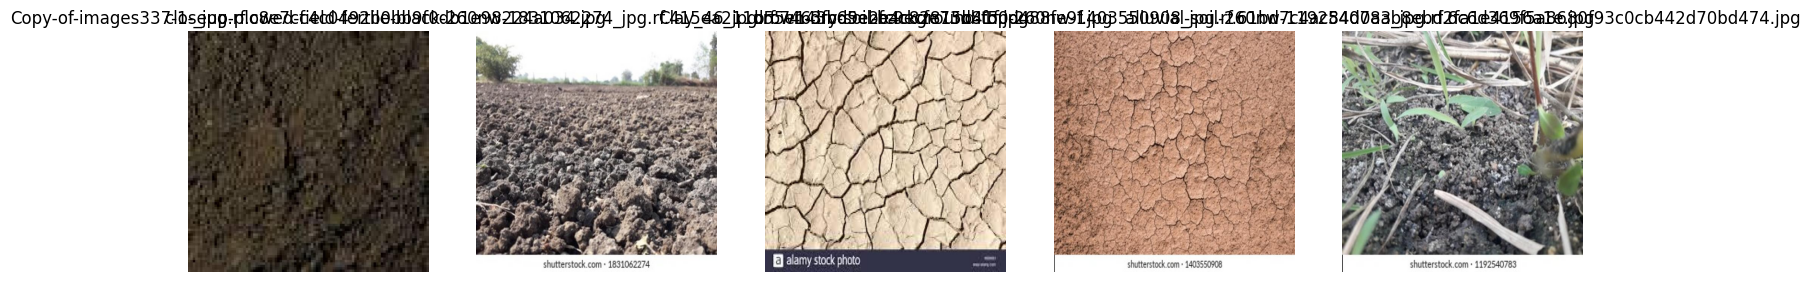

In [ ]:
sample_imgs = random.sample(os.listdir(img_folder), 5)

plt.figure(figsize=(18, 6))
for i, img_file in enumerate(sample_imgs):
    img = cv2.imread(os.path.join(img_folder, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis("off")

Image Quality Enhancement

In [ ]:
def denoise(img):
    return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

def sharpen(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def blur(img):
    return cv2.GaussianBlur(img, (7, 7), 0)


Unique img shape

In [ ]:
sizes = []
for file in os.listdir(img_folder):
    img = cv2.imread(os.path.join(img_folder, file))
    sizes.append(img.shape[:2])

sizes = np.array(sizes)
print("Unique Image Sizes:")
np.unique(sizes, axis=0)


Unique Image Sizes:


array([[640, 640]])

Class Names & Class Distribution

In [ ]:
with open(dataset.location + "/data.yaml") as f:
    data_yaml = yaml.safe_load(f)

classes = data_yaml["names"]
print("Classes:", classes)


Classes: ['Alluvial Soil', 'Black Soil', 'Clay Soil', 'Red Soil']


Class Count Plot

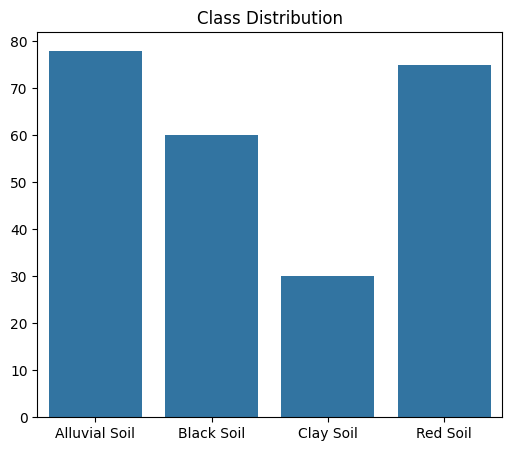

In [ ]:
label_files = glob.glob(lbl_folder + "/*.txt")

class_counts = {cls: 0 for cls in classes}

for lf in label_files:
    with open(lf) as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counts[classes[class_id]] += 1

plt.figure(figsize=(6, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution")
plt.show()


Bounding Box Count Analysis

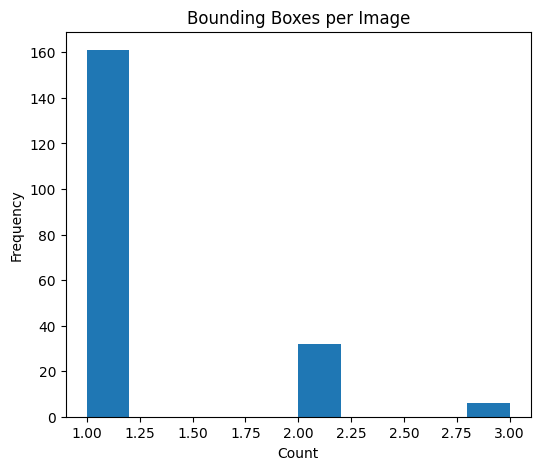

In [ ]:
bbox_count = []

for lf in label_files:
    with open(lf) as f:
        bbox_count.append(len(f.readlines()))

plt.figure(figsize=(6, 5))
plt.hist(bbox_count, bins=10)
plt.title("Bounding Boxes per Image")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()


Define ALL preprocessing functions

In [ ]:
def hist_equalize(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

def random_brightness(img):
    value = random.randint(-40, 40)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = np.clip(hsv[:,:,2] + value, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def sharpen(img):
    k = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    return cv2.filter2D(img, -1, k)

def flip(img):
    return cv2.flip(img, 1)

def rotate(img):
    ang = random.randint(-10, 10)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), ang, 1)
    return cv2.warpAffine(img, M, (w, h))

def final_resize(img):
    return cv2.resize(img, (640, 640))

def final_norm(img):
    return (img / 255.0).astype("float32")


Apply preprocessing to every image

In [ ]:
valid_ext = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

count = 0

for file in os.listdir(img_folder):
    if file.endswith(valid_ext):

        try:
            img_path = os.path.join(img_folder, file)
            img = cv2.imread(img_path)

            # Skip unreadable files
            if img is None:
                print("Skipping corrupt file:", file)
                continue

            # COLOR STEPS
            img = hist_equalize(img)
            img = random_brightness(img)
            img = sharpen(img)

            # AUGMENTATION
            if random.random() > 0.5:
                img = flip(img)
            img = rotate(img)

            # FINAL FIX
            img = final_resize(img)
            img = final_norm(img)

            # SAVE
            final_img = (img * 255).astype("uint8")
            cv2.imwrite(os.path.join(output_folder, file), final_img)

            count += 1

        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

print("Preprocessing Completed!")
print("Total processed images:", count)


Error processing black-land-plant-background-top-260nw-1715884504_jpg.rf.8e446d8f914d4a27336ee131da34fd7f.jpg: Python integer -12 out of bounds for uint8
Error processing alluvial-soil-geographical-study-reference-260nw-1988780216_jpg.rf.965972bef3851bbe5a99849203b9f261.jpg: Python integer -9 out of bounds for uint8
Error processing stock-photo-fossilized-concretions-in-the-alluvial-sand-soil-1205780284_jpg.rf.990dffdc2bd80d8b969f6985bea4ea26.jpg: Python integer -36 out of bounds for uint8
Error processing Copy-of-clay_jpg.rf.52aa3b0d5dad68a0b415a6cb4b42b102.jpg: Python integer -28 out of bounds for uint8
Error processing alluvial-soil-geographical-study-reference-260nw-1992713210_jpg.rf.9d286d4ae437ee1149524a8c9323aea6.jpg: Python integer -37 out of bounds for uint8
Error processing natural-silty-soil-background-brown-600w-234187528_jpg.rf.0243e582888baf29af87f60ab5cf1b4d.jpg: Python integer -31 out of bounds for uint8
Error processing dark-black-soil-texture-blackground-260nw-1140149